### Training Notebook 

#### Importing Libraries 

In [16]:
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import confmat as cfmat
import cv2 as cv
import numpy as np
import os
from imutils import paths
import pickle
%matplotlib inline

#### Get Data

In [17]:
dataset_path = '../data/Train_data'
categories = os.listdir(dataset_path)
print("Training path: ", dataset_path)
print("Training categories: ", categories)

Training path:  ../data/Train_data
Training categories:  ['Apple', 'Mango']


In [18]:
image_paths = []
image_classes = []
class_id = 0
for category in categories:
    dir = os.path.join(dataset_path, category)
    class_path = list(paths.list_images(dir))
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1
    
print(image_classes)
print(len(image_classes))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
22


#### KeyPoints and Descriptors of images

In [19]:
sift=cv.xfeatures2d.SIFT_create()
des_list = []
print("Now Script,Calculating all the descriptors and keypoints...")
for image_path in image_paths:
    print("Calculating for image ["+ image_path +"]", end="\r")
    im  = cv.imread(image_path)
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray,None)
    des_list.append((image_path, kp, des))

print("\nDone!")

Now Script,Calculating all the descriptors and keypoints...
Calculating for image [../data/Train_data\Mango\Mango_9.jpg]]
Done!


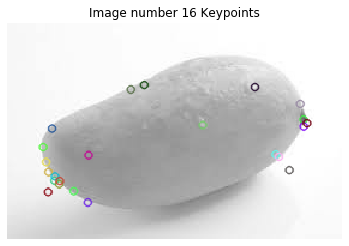

In [22]:
IMAGE_N = 16
im = cv.imread(des_list[IMAGE_N][0])
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(gray, None)
kpImg = cv.drawKeypoints(gray, kp, im)
plt.imshow(im, cmap='gray')
plt.axis("off")
plt.title("Image number "+str(IMAGE_N)+" Keypoints")
plt.show()

#### Stack All Desciptors/Keypoints Vertically in Numpy Array

In [23]:
print("Now stacking keypoint in Numpy Array........")
descriptors = des_list[0][2]
for image_path, keypoints, descriptor in des_list[1:]:
    print("Calculating for image ["+ image_path +"]", end="\r")
    descriptors = np.vstack((descriptors, descriptor))
print("\nDone!")

Now stacking keypoint in Numpy Array........
Calculating for image [../data/Train_data\Mango\Mango_9.jpg]
Done!


#### Save the Descriptor/Key Points in Seperate file

In [24]:
pickle.dump(descriptors, open('Fruit_Descriptor.sav', 'wb'))

#### Apply K_Means Clustering Algorithm 

In [25]:
k = 500
voc, variance = kmeans(descriptors, k, 1)
print("K_Means Clustering Work Done.....")

K_Means Clustering Work Done.....


In [26]:
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    print("Calculating distance for image..... "+str(i)+"...", end="\r")
    words, distance = vq(des_list[i][2],voc)
    for w in words:
        im_features[i][w] += 1

#### Plotting Histogram with K=500

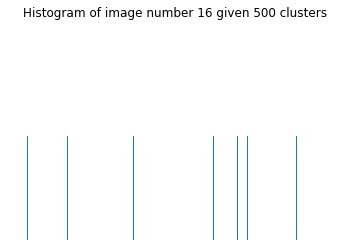

In [28]:
plt.bar(range(k), im_features[IMAGE_N])
plt.axis("off")
plt.title("Histogram of image number "+ str(IMAGE_N) +" given "+ str(k) + " clusters")
plt.show()

#### Weighted/Un-Weighted Histogram 

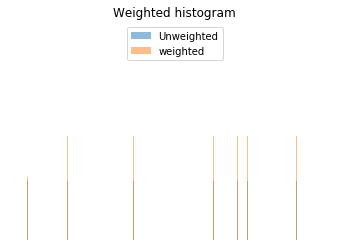

In [29]:
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths) + 1) / (1.0*nbr_occurences + 1)), 'float32')
scaled_im_features = im_features * idf
plt.bar(range(k), im_features[IMAGE_N], alpha=0.5)
plt.bar(range(k), scaled_im_features[IMAGE_N], alpha=0.5)
plt.axis("off")
plt.title("Weighted histogram")
plt.legend(['Unweighted', 'weighted'])
plt.show()

#### Features Normalization 

In [30]:
stdSlr = StandardScaler().fit(scaled_im_features)
scaled_im_features = stdSlr.transform(scaled_im_features)

#### Train The Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(max_depth=None, random_state=0)
baggingclf = BaggingClassifier(RandomForestClassifier())
cv = cross_validate(baggingclf, X=scaled_im_features, y=image_classes, return_train_score=True, cv=10)
print("Training Score: ", cv['train_score'].mean())
print("Mean cross-validation score: ", cv['test_score'].mean())
clf.fit(X=scaled_im_features, y=image_classes)
plt.show()

C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\chr04\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Training Score:  0.9649999999999999
Mean cross-validation score:  0.55


In [32]:
clf = LinearSVC()
cv = cross_validate(clf, X=scaled_im_features, y=image_classes, return_train_score=True, cv=5)
print("Training Score: ", cv['train_score'].mean())
print("Mean cross-validation score: ", cv['test_score'].mean())
clf.fit(X=scaled_im_features, y=image_classes)

Training Score:  1.0
Mean cross-validation score:  0.8800000000000001


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

#### Save Model in Output File 

In [33]:
joblib.dump((clf, categories, stdSlr, k, voc, idf), "Fruit_CLassifier.pkl", compress=3)

['Fruit_CLassifier.pkl']